## Double checking protein contact map distributions

### 1. Reading in KLIFS data set

In [1]:
import glob
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np
from MDAnalysis.analysis import distances
from MDAnalysis.analysis import contacts
import os

# Needed for secondary structure counting
from collections import Counter

In [2]:
# Reading in all cleaned pdbs
# pdbs = glob.glob('../data/clean/*.pdb')

In [2]:
pdbs = glob.glob('/home/jguven/Projects/link_lengths/pdb_files/*.ent')
pdbs= np.load('300_lengths.npy')

In [4]:
# Careful this cell will take a moment to execute!
lengths = []
lengths_names = []
for protein in pdbs:
    u = mda.Universe(protein)
    ca_s = u.select_atoms("name CA")
    if np.logical_and(len(ca_s)>=285, len(ca_s)<=315):
        lengths_names.append(protein)
    lengths.append(len(ca_s))

/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HG
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AS
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: AL
  warnings.warn("Fa

KeyboardInterrupt: 

In [100]:
np.save('300_lengths.npy', lengths_names)

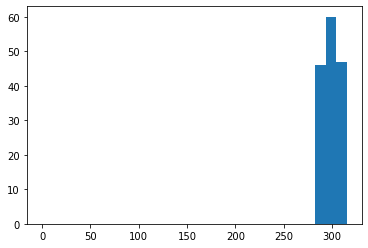

In [6]:
# plotting length distribution
hist_info = plt.hist(lengths,bins=np.linspace(0,315,30))
# plt.xlim(285,315)

In [15]:
# Find all entries that fall in the right interval
mask_interval = np.where(np.logical_and(np.array(lengths)>=285, np.array(lengths)<=315))

### 2. Generate contact maps for valid proteins

In [6]:
mask_interval[0][0] # Yay first protein is of the right category.

0

In [3]:
def get_adjacency_matrix(protein_file, radius=8, return_distances=False):
    # Calpha atom selection
    u = mda.Universe(protein_file)
    ca_s = u.select_atoms('name CA')
    
    # distance array from ca positions
    distance_array= distances.self_distance_array(ca_s.positions)
    # contacts based on distance array
    contacts_array = contacts.contact_matrix(distance_array, radius=radius)
    
    # generate adjacecy array
    adjacency_array = np.zeros(len(contacts_array))
    adjacency_array[contacts_array==True] = 1
    
    # convert distance array back to symmetric matrix
    n = len(ca_s.positions)
    distance_mat = np.zeros((n,n))
    distance_mat[np.triu_indices(distance_mat.shape[0], k = 1)] = distance_array
    np.fill_diagonal(distance_mat, 0)
    # loop to make symmetric loooping faster than np.where(ut,ut, ut.T)
    for i in range(len(distance_mat)):
        for j in range(i):
            distance_mat[i,j] = distance_mat[j,i]
        
    # Now let's look at the adjacency matrix
    PCM_mat = np.zeros((n,n))
    PCM_mat[np.triu_indices(PCM_mat.shape[0], k = 1)] = adjacency_array
    np.fill_diagonal(PCM_mat, 1)
    A_ij = np.where(PCM_mat,PCM_mat,PCM_mat.T) # now using cool trick and not direct loop
    
    if return_distances == True:
        return A_ij,distance_mat
    else:
        return A_ij

In [4]:
a,b = get_adjacency_matrix(pdbs[12], return_distances=True)

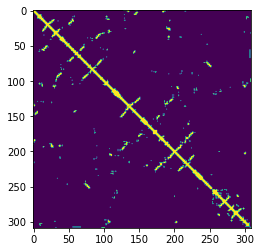

In [5]:
plt.imshow(a)

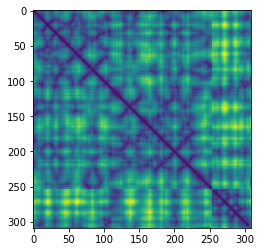

In [6]:
plt.imshow(b)

### 3. Now we need to look at the distance distributions

In [7]:
distance_distribution_array = np.linspace(1,200, 100) # largest bit in interval

In [8]:
def return_discrete_distances(adjancy):
    discret_distances = []
    for i in range(len(adjancy)):
        for j in range(len(adjancy)):
            if adjancy[i][j] == 1:
                dist = j-i
                discret_distances.append(np.abs(dist))
    return discret_distances

### 4. Now let's loop over the whole pdb dataset

In [9]:
hist_data = []
for p in pdbs:
    # print(p)
    a = get_adjacency_matrix(p)
    dists = return_discrete_distances(a)
    hist_data.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])

/tmp/ipykernel_1429019/2001156136.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_data.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: HG
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: SE
  warnings.warn("Failed to guess the mass for the following atom types: {}".fo

[]

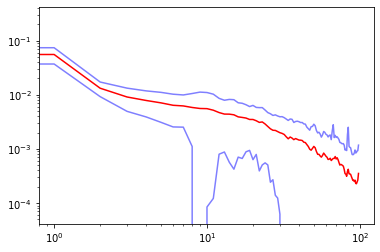

In [10]:
mean = np.mean(hist_data, axis=0)
std = np.std(hist_data, axis=0)
plt.plot(mean, 'r')
plt.plot(mean+std, 'b', alpha=0.5)
plt.plot(mean-std, 'b', alpha=0.5)
plt.loglog()

(0.0005, 0.2)

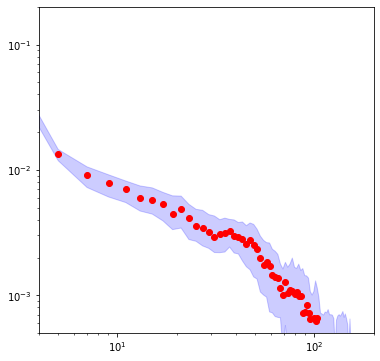

In [11]:
lower, median, upper = np.quantile(hist_data, [0.33,0.5,0.66], axis=0)
fig = plt.figure(figsize=(6,6))
median = np.median(hist_data, axis=0)
plt.plot(np.array(distance_distribution_array[:-1]),median, 'r', marker = 'o', lw = 0)
plt.fill_between(np.array(distance_distribution_array[:-1]), np.array(upper), np.array(lower),color= 'b', alpha=0.2)
#plt.plot(lower, 'b', alpha=0.5)
#plt.plot(mean, 'g')
#plt.plot(mean+std, 'orange', alpha=0.5)
#plt.plot(mean-std, 'orange', alpha=0.5)
plt.loglog()
plt.xlim(4,200)
plt.ylim(0.0005,0.2)

In [157]:
len(lower)

99

### 4. DSSP info

In [12]:
def get_sec_struct(fname, dssp_path):
    
    """
    H = α-helix
    B = residue in isolated β-bridge
    E = extended strand, participates in β ladder
    G = 3-helix (310 helix)
    I = 5 helix (π-helix)
    T = hydrogen bonded turn
    S = bend
    """
    
    #call DSSP
    try:
        import subprocess
        subprocess.check_call("%s %s -o result.dssp"%(dssp_path, fname), shell=True)
        fin=open("result.dssp","r")
    except Exception as e:
        raise Exception("Could not calculate secondary structure! %s"%e)

    #parse output
    readit=False
    secstruct=[]
    for line in fin:

        if readit:
            try:
                if line[13:15] == '!*' or line[13] == '!':
                    continue
                else:
                    ss = line[16]
                    if line[16] == " ":
                        ss = "-"

                    secstruct.append(ss)
            except:
                continue

        if "#" in line:
            readit=True

    fin.close()

    # clean temporary files
    os.remove("result.dssp")

    return np.array(secstruct)

In [13]:
secstruc_data = []
for p in pdbs:
    second_struct = get_sec_struct(p, '/usr/bin/dssp')
    c=Counter(second_struct)
    chain_length = len(second_struct)
    for key in c:
        c[key] = c[key]/chain_length
    secstruc_data.append(c)

In [14]:
import pandas as pd

In [15]:
data = pd.DataFrame.from_dict(secstruc_data)

In [16]:
data

,-,B,T,S,G,H,E,I
0,0.271186,0.030508,0.169492,0.108475,0.030508,0.122034,0.267797,NaN
1,0.224080,0.006689,0.076923,0.086957,0.043478,0.187291,0.374582,NaN
2,0.187898,0.006369,0.146497,0.070064,0.041401,0.184713,0.331210,0.031847
3,0.144366,0.003521,0.080986,0.035211,0.059859,0.580986,0.052817,0.042254
4,0.221831,0.021127,0.066901,0.137324,0.063380,NaN,0.489437,NaN
...,...,...,...,...,...,...,...,...
587,0.199357,0.006431,0.112540,0.109325,0.022508,0.289389,0.260450,NaN
588,0.229452,0.030822,0.171233,0.071918,NaN,0.102740,0.393836,NaN
589,0.155556,NaN,0.098413,0.041270,0.060317,0.504762,0.139683,NaN
590,0.166667,0.013072,0.094771,0.013072,NaN,0.712418,NaN,NaN


Text(0, 0.5, 'beta_percent')

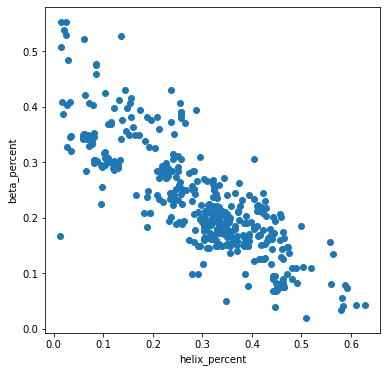

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(data['H'],data['B']+data['E'])
plt.xlabel('helix_percent')
plt.ylabel('beta_percent')

### 5. Alpha fold data

In [4]:
import pandas as pd
import urllib.request
import numpy as np

In [6]:
alpha_300 = pd.read_excel('../data/pdbs/uniprot_300s.xlsx')

In [18]:
pdbs_alpha = glob.glob('data/alpha_fold/*.pdb')

### Let's look at DSSP first and wee out some strange structures
i.e. if helix content less than 0.3 and sheet content less than 0.2

In [19]:
secstruc_data_alpha = []
for p in pdbs_alpha[:5000]:
    second_struct = get_sec_struct(p, '/usr/bin/dssp')
    c=Counter(second_struct)
    chain_length = len(second_struct)
    for key in c:
        c[key] = c[key]/chain_length
    secstruc_data_alpha.append(c)

In [20]:
data_alpha = pd.DataFrame.from_dict(secstruc_data_alpha)

Text(0, 0.5, 'beta_percent')

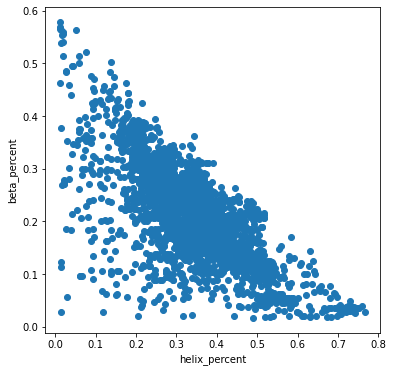

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(data_alpha['H'],data_alpha['B']+data_alpha['E'])
plt.xlabel('helix_percent')
plt.ylabel('beta_percent')

### Weeding out some shitty strucutres

In [22]:
confidence_info=[]
for p in pdbs_alpha[:5000]:
    f = open(p)
    data = f.readlines()
    f.close()
    confidence_score = []
    conf_dic = {}
    for l in data:
        if l.startswith('ATOM'):
            curr_line =l.split()
            confidence_score.append(float(curr_line[-2]))
    conf_dic['mean'] = np.mean(confidence_score)
    conf_dic['std'] = np.std(confidence_score)
    conf_dic['name'] = p
    confidence_info.append(conf_dic)

In [23]:
confidence_df = pd.DataFrame.from_dict(confidence_info)

In [24]:
filter = confidence_df["mean"]>90.0
new_frame = confidence_df.where(filter).dropna()

In [25]:
pdbs_good_alpha = new_frame['name']

In [26]:
pdbs_good_alpha

0       data/alpha_fold/AF-Q04T63-F1-model_v2.pdb
1       data/alpha_fold/AF-Q818V3-F1-model_v2.pdb
4       data/alpha_fold/AF-P93349-F1-model_v2.pdb
6       data/alpha_fold/AF-Q6GBZ5-F1-model_v2.pdb
7       data/alpha_fold/AF-Q0TLW1-F1-model_v2.pdb
                          ...                    
4993    data/alpha_fold/AF-Q1D980-F1-model_v2.pdb
4994    data/alpha_fold/AF-Q6ALW6-F1-model_v2.pdb
4995    data/alpha_fold/AF-Q8DUP5-F1-model_v2.pdb
4998    data/alpha_fold/AF-Q7VRS3-F1-model_v2.pdb
4999    data/alpha_fold/AF-P46539-F1-model_v2.pdb
Name: name, Length: 3121, dtype: object

Text(0, 0.5, 'beta_percent')

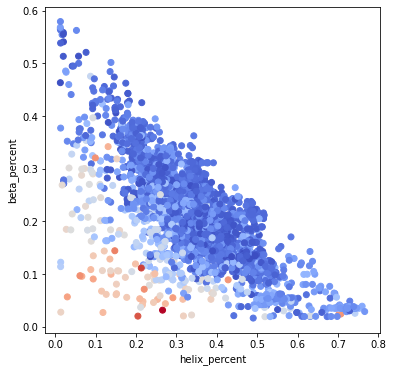

In [27]:
plt.figure(figsize=(6,6))
plt.scatter(data_alpha['H'],data_alpha['B']+data_alpha['E'], c=confidence_df['mean'], cmap='coolwarm_r')
plt.xlabel('helix_percent')
plt.ylabel('beta_percent')
        

In [42]:
np.mean(confidence_score)

92.59212721145745

In [28]:
hist_data_alpha_good = []
for p in pdbs_good_alpha:
    # print(p)
    a = get_adjacency_matrix(p)
    dists = return_discrete_distances(a)
    hist_data_alpha_good.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])

/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/tmp/ipykernel_1429019/4275352705.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_data_alpha_good.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])


In [29]:
hist_data_alpha = []
for p in pdbs_alpha:
    # print(p)
    a = get_adjacency_matrix(p)
    dists = return_discrete_distances(a)
    hist_data_alpha.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])

/tmp/ipykernel_1429019/2808869113.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_data_alpha.append(np.histogram(dists, bins = distance_distribution_array,normed=True)[0])
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the fo

ValueError: could not convert string to float: ''

In [34]:
len(hist_data_alpha)
len(hist_data)

592

(0.0005, 0.2)

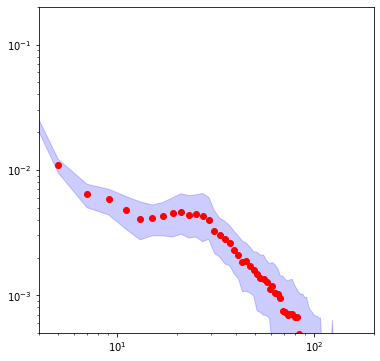

In [27]:
lower_alpha, median_alpha, upper_alpha = np.quantile(hist_data_alpha, [0.33,0.5,0.66], axis=0)
fig = plt.figure(figsize=(6,6))
median_alpha = np.median(hist_data_alpha, axis=0)
plt.plot(np.array(distance_distribution_array[:-1]),median_alpha, 'r', marker = 'o', lw = 0)
plt.fill_between(np.array(distance_distribution_array[:-1]), np.array(upper_alpha), np.array(lower_alpha),color= 'b', alpha=0.2)
#plt.plot(lower, 'b', alpha=0.5)
#plt.plot(mean, 'g')
#plt.plot(mean+std, 'orange', alpha=0.5)
#plt.plot(mean-std, 'orange', alpha=0.5)
plt.loglog()
plt.xlim(4,200)
plt.ylim(0.0005,0.2)

(0.0005, 0.2)

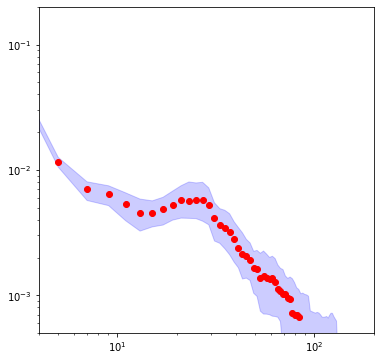

In [68]:
lower_alpha, median_alpha, upper_alpha = np.quantile(hist_data_alpha_good, [0.33,0.5,0.66], axis=0)
fig = plt.figure(figsize=(6,6))
median_alpha = np.median(hist_data_alpha_good, axis=0)
plt.plot(np.array(distance_distribution_array[:-1]),median_alpha, 'r', marker = 'o', lw = 0)
plt.fill_between(np.array(distance_distribution_array[:-1]), np.array(upper_alpha), np.array(lower_alpha),color= 'b', alpha=0.2)
#plt.plot(lower, 'b', alpha=0.5)
#plt.plot(mean, 'g')
#plt.plot(mean+std, 'orange', alpha=0.5)
#plt.plot(mean-std, 'orange', alpha=0.5)
plt.loglog()
plt.xlim(4,200)
plt.ylim(0.0005,0.2)

(0.0005, 0.02)

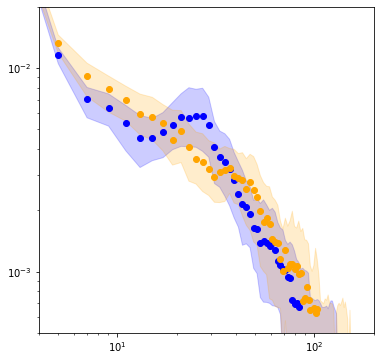

In [70]:
# Plot both pdb and alpha

lower_alpha, median_alpha, upper_alpha = np.quantile(hist_data_alpha_good, [0.33,0.5,0.66], axis=0)
fig = plt.figure(figsize=(6,6))
median_alpha = np.median(hist_data_alpha_good, axis=0)
# alpha fold data
plt.plot(np.array(distance_distribution_array[:-1]),median_alpha, 'blue', marker = 'o', lw = 0)
plt.fill_between(np.array(distance_distribution_array[:-1]), np.array(upper_alpha), np.array(lower_alpha),color= 'blue', alpha=0.2)

# pdb data

plt.plot(np.array(distance_distribution_array[:-1]),median, 'orange', marker = 'o', lw = 0)
plt.fill_between(np.array(distance_distribution_array[:-1]), np.array(upper), np.array(lower),color= 'orange', alpha=0.2)



plt.loglog()
plt.xlim(4,200)
plt.ylim(0.0005,0.02)

In [8]:
mean = np.mean(hist_data, axis=0)
std = np.std(hist_data, axis=0)
plt.plot(mean, 'r')
plt.plot(mean+std, 'b', alpha=0.5)
plt.plot(mean-std, 'b', alpha=0.5)
plt.loglog()

/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/amey/miniconda3/envs/MDAnalysis/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [58]:
lower, median, upper = np.quantile(hist_data, [0.33,0.5,0.66], axis=0)

[]

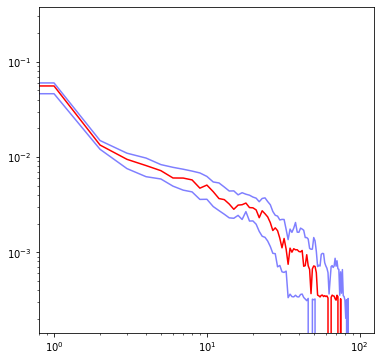

In [59]:
lower, median, upper = np.quantile(hist_data, [0.33,0.5,0.66], axis=0)
fig = plt.figure(figsize=(6,6))
median = np.median(hist_data, axis=0)
plt.plot(median, 'r')
plt.plot(upper, 'b', alpha=0.5)
plt.plot(lower, 'b', alpha=0.5)
#plt.plot(mean, 'g')
#plt.plot(mean+std, 'orange', alpha=0.5)
#plt.plot(mean-std, 'orange', alpha=0.5)
plt.loglog()

In [ ]:
counter = 0
for entry in alpha_300['Entry']:
    # print(f"At entry {counter}/{len(uniprot_IDs)}")
    download = f"https://alphafold.ebi.ac.uk/files/AF-{entry}-F1-model_v2.pdb"

    try:
        file_name = f"../data/alphafold/pdb_files/AF-{entry}-F1-model_v2.pdb"
        urllib.request.urlretrieve(download, file_name)
    except:
        print(f"Error downloading {entry}" )

    counter += 1

Error downloading S8B3I4
Error downloading S7ZEI0
Error downloading Q9YWQ0
Error downloading Q9YW20
Error downloading Q9YUD3
Error downloading Q9YPS7
Error downloading Q9YMG2
Error downloading Q9YJJ8
Error downloading Q9WT46
Error downloading Q9WT38
Error downloading Q9WT35
Error downloading Q9WQ77
Error downloading Q9WQ76
Error downloading Q9WIJ5
Error downloading Q9WBI3
Error downloading Q9TUA1
Error downloading Q9TU99
Error downloading Q9TU84
Error downloading Q9T1W1
Error downloading Q9T1P5
Error downloading Q9T1D6
Error downloading Q9QTF2
Error downloading Q9QSP3
Error downloading Q9QJ43
Error downloading Q9QJ27
Error downloading Q9QJ17
Error downloading Q9QBG0
Error downloading Q9QB92
Error downloading Q9PY93
Error downloading Q9MCC1
Error downloading Q9JGU0
Error downloading Q9JFA1
Error downloading Q9J5C9
Error downloading Q9J540
Error downloading Q9J529
Error downloading Q9J523
Error downloading Q9J519
Error downloading Q9J509
Error downloading Q9J3N2
Error downloading Q9IR51


In [73]:
c=Counter(second_struct)

In [75]:
c['H']

36

In [92]:
# Alpha fold
alpha_data = glob.glob('data/alpha_fold/*.pdb')

len(alpha_data)



7831

In [89]:
helix_percent = []
beta_percent = []
no_secondary_structure = []
for p in alpha_data:
    second_struct = get_sec_struct(p, '/usr/bin/dssp')
    c=Counter(second_struct)
    helix_percent.append(c['H']/len(second_struct))
    beta_percent.append(c['E']/len(second_struct))
    if c['H'] ==0 and c["E"] == 0:
        no_secondary_structure.append(p)

Text(0, 0.5, 'beta_percent')

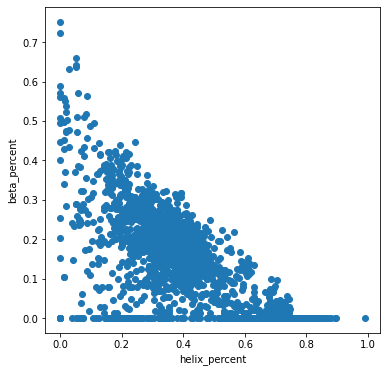

In [90]:
plt.figure(figsize=(6,6))
plt.scatter(helix_percent,beta_percent)
plt.xlabel('helix_percent')
plt.ylabel('beta_percent')

In [91]:
no_secondary_structure

['data/alpha_fold/AF-P21135-F1-model_v2.pdb',
 'data/alpha_fold/AF-P30009-F1-model_v2.pdb',
 'data/alpha_fold/AF-P23490-F1-model_v2.pdb',
 'data/alpha_fold/AF-P23624-F1-model_v2.pdb',
 'data/alpha_fold/AF-P26645-F1-model_v2.pdb',
 'data/alpha_fold/AF-P31936-F1-model_v2.pdb']